In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import h5py
from scipy import io
import os
import glob
import pywt

preparing data for training

(283, 901)


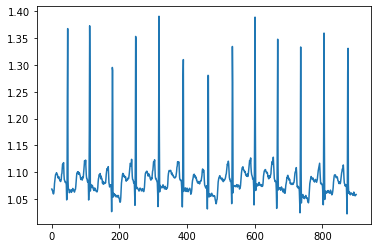

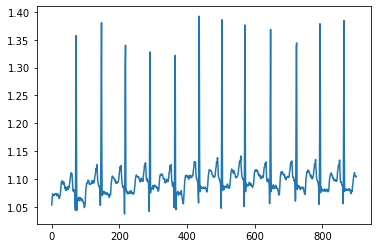

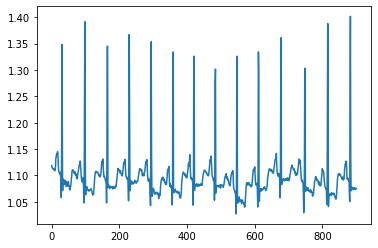

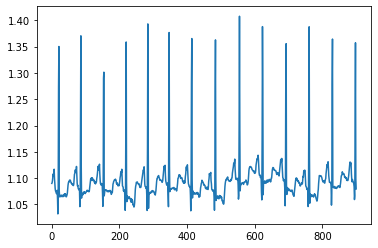

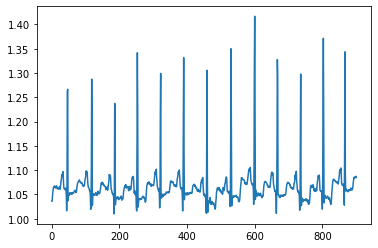

In [2]:
arr = []
for file in glob.glob('MLII/1 NSR/*.mat'):
    arr.append(file) 

arr = sorted(arr, key=lambda x:x[:])

l = 283
ll = 1
d = np.int(3600/ll)
stride = 2
data = []
for i in range(l):
    db = io.loadmat(arr[i])    
    for j in range(ll):
        data.append(db['val'][0, j*d:(j+1)*d]/np.amax(db['val'][0, :]))
data = np.asarray(data).reshape(l*ll, d)[:, ::stride]  

#seq_in = data

seq_in = []
for i in range(len(data)):
    cA, cD = pywt.dwt(data[i], 'db2')
    seq_in.append(cA)
seq_in = np.asarray(seq_in)
    
print (seq_in.shape)  

for i in range(5):
    plt.figure()
    plt.plot(seq_in[i, :])

GANLSTM for ECG data

In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional, ConvLSTM2D, MaxPooling1D, Conv1D, Flatten
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, RepeatVector
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l1_l2

Using TensorFlow backend.


In [11]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.latent_dim = 16
        self.disc_loss = []
        self.gen_loss = []
        
        optimizer_d = Adam(0.0001, 0.45)
        optimizer_g = Adam(0.0002, 0.45)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_d, metrics=['accuracy'])

        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(generated_seq)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    def build_discriminator(self):

        model = Sequential()
        model.add(Reshape((self.seq_length, 1)))  
        model.add(Conv1D(filters=32, kernel_size=8))
        model.add(MaxPooling1D(pool_size=3))
        model.add(LeakyReLU(alpha=0.2))         
        model.add(Dropout(0.4))                
        model.add(Conv1D(filters=64, kernel_size=8))
        model.add(MaxPooling1D(pool_size=3))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))                                
        model.add(Conv1D(filters=128, kernel_size=8))
        model.add(MaxPooling1D(pool_size=3))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))
        model.add(Conv1D(filters=256, kernel_size=8))
        model.add(MaxPooling1D(pool_size=3))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))          
        model.add(Flatten())         
        model.add(Dense(1, activation='sigmoid'))

        seq = Input(shape=(self.seq_length,))
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()  
        model.add(RepeatVector(self.seq_length))
        model.add(LSTM(16, return_sequences=True, kernel_regularizer=l1_l2(l1=0.0, l2=0.0))) 
        model.add(Dense(8))
        model.add(BatchNormalization(momentum=0.9))  
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.4))        
        model.add(Dense(1, activation='tanh'))
        model.add(Reshape((self.seq_length,)))
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=64, sample_interval=10):

        X_train = seq_in
        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            noise = np.random.normal(1, 0.01, (batch_size, self.latent_dim)) 
            gen_seqs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(1, 0.01, (batch_size, self.latent_dim))                       
            g_loss = self.combined.train_on_batch(noise, real)

            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.disc_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        self.plot_loss()            
            
    def plot_loss(self):
        
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()            

In [12]:
gan = GAN(rows=seq_in.shape[1])    
gan.train(epochs=500, batch_size=64, sample_interval=10)

/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.691252, acc.: 43.75%] [G loss: 0.660870]


/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10 [D loss: 0.587650, acc.: 54.69%] [G loss: 0.624252]
20 [D loss: 0.666449, acc.: 50.00%] [G loss: 0.630017]
30 [D loss: 0.608667, acc.: 55.47%] [G loss: 0.608283]
40 [D loss: 0.610153, acc.: 65.62%] [G loss: 0.638795]
50 [D loss: 0.716395, acc.: 47.66%] [G loss: 0.707158]
60 [D loss: 0.685284, acc.: 50.78%] [G loss: 0.679879]
70 [D loss: 0.715106, acc.: 42.97%] [G loss: 0.681221]
80 [D loss: 0.663600, acc.: 51.56%] [G loss: 0.623464]
90 [D loss: 0.665414, acc.: 50.00%] [G loss: 0.619728]
100 [D loss: 0.392880, acc.: 92.97%] [G loss: 0.595126]
110 [D loss: 0.720811, acc.: 50.00%] [G loss: 0.632753]
120 [D loss: 0.700034, acc.: 47.66%] [G loss: 0.652067]
130 [D loss: 0.657833, acc.: 52.34%] [G loss: 0.651628]
140 [D loss: 0.714081, acc.: 50.00%] [G loss: 0.724551]
150 [D loss: 0.729579, acc.: 45.31%] [G loss: 0.740971]
160 [D loss: 0.689864, acc.: 57.03%] [G loss: 0.685262]
170 [D loss: 0.676558, acc.: 53.91%] [G loss: 0.686179]
180 [D loss: 0.711001, acc.: 50.78%] [G loss: 0.713581]
1

KeyboardInterrupt: 

generate synthetic ecg

In [ ]:
noise = np.random.normal(1, 0.01, (1, gan.latent_dim))
gen_seqs = gan.generator.predict(noise).reshape(gan.seq_length)
plt.figure()
plt.plot(gen_seqs)